importing necessary Libraries and packages

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

plt.style.use ('ggplot')

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

reading the data in

In [91]:
df = pd.read_csv ('Reviews.csv')
print (df.shape)

#selecting only 1000 of the dataset. 
df = df.head (1000)
print (df.shape)

(568454, 10)
(1000, 10)


In [92]:
df.head ()
df.columns


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

Exploring the Data

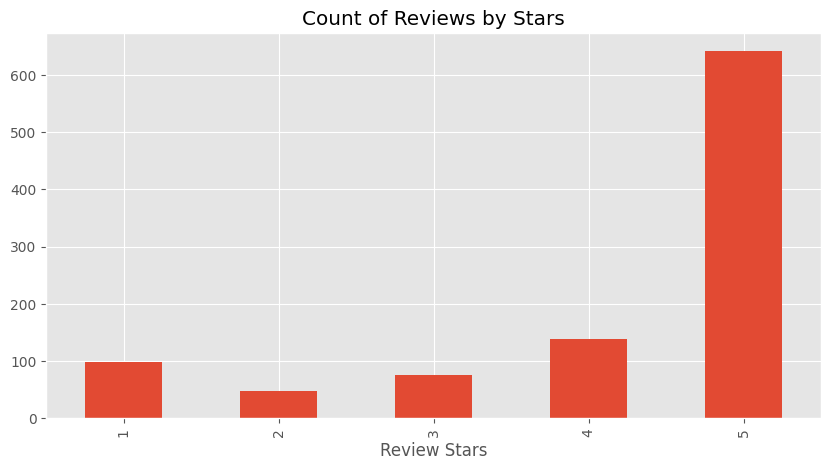

In [93]:
ax = df['Score'].value_counts ().sort_index ().plot (kind=
                                                     'bar',
                                                     title='Count of Reviews by Stars',
                                                     figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show ()


Training the model from transfomers

In [98]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [99]:
#testing an example to see how it works
example = df['Text'][40]
print (example)

The variety packs taste great!<br /><br />I have them every morning. At $0.30 cents per meal, I don't understand why everyone on earth isn't buying this stuff up.<br /><br />Maple and brown sugar is terrific, followed by apples and cinnamon, followed by regular. You don't get tired of the same ole thing, and they taste great.<br /><br />I just boil water from a small pot, empty the packet or 2 in a bowl, pour in boiling water, and watch it expand to 2x its size!<br /><br />Taste really good and takes minutes to prepare.<br /><br />Not sure why everyone on earth isn't this. Convenient, healthy, very quick, excellent quality, and extremely cheap...


Testing the Roberta_model to see if it works

In [100]:
#using the roberta_model
encoded_text = tokenizer (example, return_tensors='pt')# this is to make it easily readable by the model
output = model (**encoded_text)
scores = output[0][0].detach().numpy ()# this takes the output from being a tensor and make it numpy and socre locally
scores = softmax (scores)
scores
scores_dict = {
    'roberta_negative' : scores [0],
    'roberta_neutral' : scores [1],
    'roberta_postive' : scores [2],

}# creating a dictionary to be able to see the scores well
print (scores_dict)


{'roberta_negative': 0.009690572, 'roberta_neutral': 0.03783324, 'roberta_postive': 0.95247614}


Applying the Model to the Entire Dataset
designing a function that can loop over series of examples

In [102]:
def polarity_scores_roberta (example):
    encoded_text = tokenizer (example, return_tensors='pt')# this is to make it easily readable by the model
    output = model (**encoded_text)
    scores = output[0][0].detach().numpy ()# this takes the output from being a tensor and make it numpy and socre locally
    scores = softmax (scores)
    scores
    scores_dict = {
        'negative' : scores [0],
        'neutral' : scores [1],
        'postive' : scores [2],

    }# creating a dictionary to be able to see the scores well
    return scores_dict

iterating over the entire data set. 

In [107]:
res = {}
for i, row in tqdm(df.iterrows (), total=len (df)):
    try:
        text= row['Text']
        myid = row ['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print (f'Broke for Id {myid}')
    #using try and except to determine the id that breaks
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for Id 83
Broke for Id 187
Broke for Id 529
Broke for Id 540
Broke for Id 746
Broke for Id 863


In [120]:
#making the results a dictionary
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head ()

,Id,negative,neutral,postive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [121]:
import os
import pandas as pd


# Get the directory path of the current script
current_directory = os.path.dirname(os.path.realpath('untitled-1.ipynb'))

# Set the file name and path to save the CSV file
file_path = os.path.join(current_directory, 'results_df.csv')

# Save the 'res' dataset to a CSV file in the same folder as the script
results_df.to_csv(file_path, index=False)


Checking the Reliability of the Scores

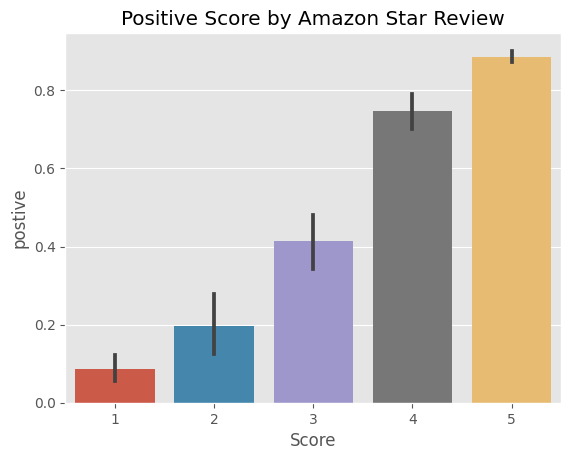

In [122]:
#assuming the that score is 5 we assume that it means the feedback is positive. 
#so checking that
results_df = pd.read_csv ('results_df.csv')
ax = sns.barplot(data=results_df, x= 'Score', y='postive')
ax.set_title ('Positive Score by Amazon Star Review')
plt.show ()

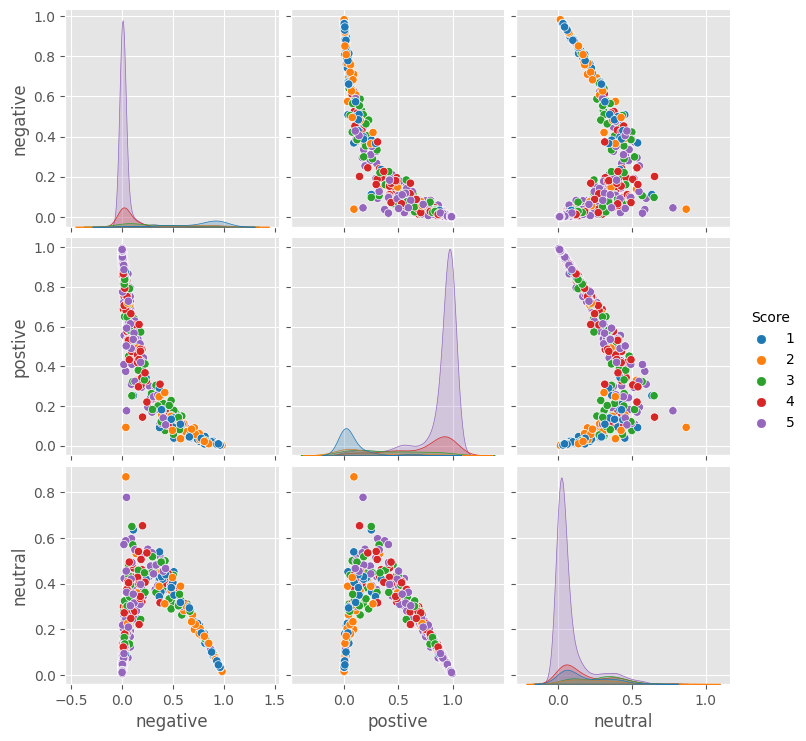

In [123]:
#also checking the 

sns.pairplot (data=results_df,
              vars=['negative', 'postive', 'neutral'],
              hue='Score',
              palette='tab10')

Determining if the reviews were positive, negative or neutral

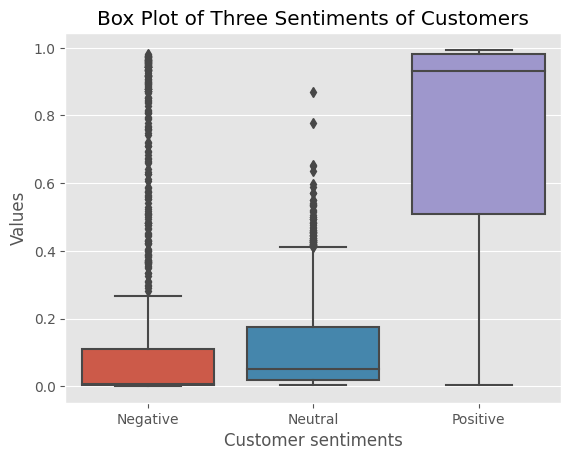

In [125]:
data = [results_df['negative'], results_df['neutral'], results_df['postive']]

# Set up the figure and axes
fig, ax = plt.subplots()

# Create the box plot
sns.boxplot(data=data, ax=ax)

# Set labels and title
ax.set_xlabel('Customer sentiments')
ax.set_ylabel('Values')
ax.set_title('Box Plot of Three Sentiments of Customers')

# Set x-axis tick labels
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])


# Show the plot
plt.show()


This is a bar chart to further checks

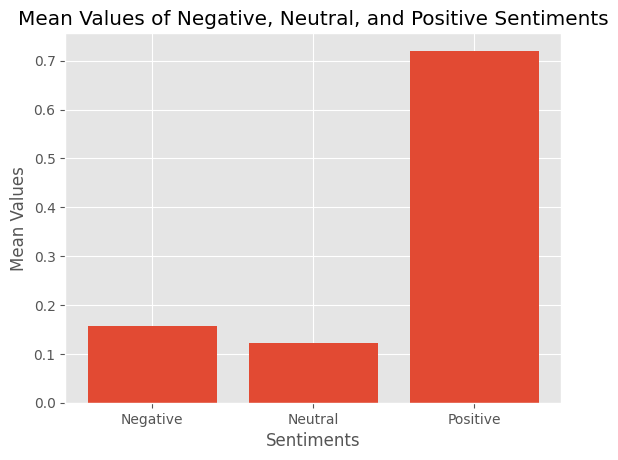

In [126]:



data = [results_df['negative'], results_df['neutral'], results_df['postive']]
labels = ['Negative', 'Neutral', 'Positive']

# Calculate the mean for each sentiment
mean_values = [column.mean() for column in data]

# Set up the figure and axes
fig, ax = plt.subplots()

# Create the bar chart
ax.bar(labels, mean_values)

# Set labels and title
ax.set_xlabel('Sentiments')
ax.set_ylabel('Mean Values')
ax.set_title('Mean Values of Negative, Neutral, and Positive Sentiments')

# Show the plot
plt.show()


Kernel Density Plot to examine the spread of the sentiments and its density

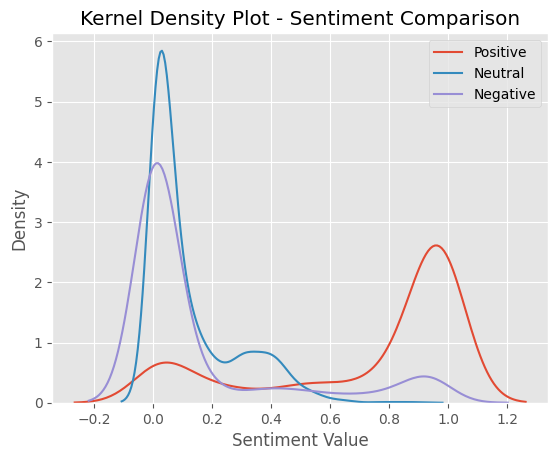

In [127]:

sns.kdeplot(data=results_df['postive'], label='Positive')
sns.kdeplot(data=results_df['neutral'], label='Neutral')
sns.kdeplot(data=results_df['negative'], label='Negative')

plt.xlabel('Sentiment Value')
plt.ylabel('Density')
plt.title('Kernel Density Plot - Sentiment Comparison')
plt.legend()
plt.show()


In [128]:
results_df.head ()


,Id,negative,neutral,postive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [117]:
results_df.head ()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [129]:
# Feature Engineering - Additional Feature Calculation
# Example: Average rating per user, profile name, and product
average_rating_per_user = results_df.groupby('UserId')['postive'].mean()
average_rating_per_profilename = results_df.groupby('ProfileName')['postive'].mean()
average_rating_per_product = results_df.groupby('ProductId')['postive'].mean()

# Add the average rating columns to the results_df DataFrame
results_df['AvgRatingPerUser'] = results_df['UserId'].map(average_rating_per_user)
results_df['AvgRatingPerProfileName'] = results_df['ProfileName'].map(average_rating_per_profilename)
results_df['AvgRatingPerProduct'] = results_df['ProductId'].map(average_rating_per_product)


# Handle missing values if any
results_df = results_df.dropna()

# Split the data into features (X) and target (y)
X = results_df[['AvgRatingPerProfileName', 'AvgRatingPerProduct', 'AvgRatingPerUser']]
y = results_df['postive']

# Standardize the numerical features (if any)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print the updated feature matrix (X)
print(X)


[[ 0.6233474   1.22355887  0.62332745]
 [-1.93197417 -3.79224189 -1.93191232]
 [ 0.5052103   0.99166939  0.50519412]
 ...
 [ 0.75615884  0.66017785  0.75613464]
 [-1.91467127  0.66017785 -1.91460997]
 [-1.97959157  0.66017785 -1.9795282 ]]


In [130]:
#PERFORMING DATA SPLITTING ETC

from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (795, 3) (795,)
Testing set shape: (199, 3) (199,)


In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Create a random forest regression model
rfr = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rfr = grid_search.best_estimator_

# Make predictions on the testing set using the best model
y_pred = best_rfr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)


Root Mean Squared Error: 0.06258107443496509
R-squared: 0.9724715358100204


In [152]:
best_rfr.feature_importances_

array([0.47142176, 0.00119455, 0.52738369])